## <center><u>Deep Learning and Neural Networks: Final Project</u></center>

#### <center>This notebooks contains the Fine-tuning of BART-Base Model</center>

### Installing the BLURR library and Bert-Score package

In [ ]:
!pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 torchtext==0.14.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu116 -U

### Installing the BLURR library and Bert-Score package

In [ ]:
!pip install ohmeow-blurr -q
!pip install bert-score -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Importing necessary modules

In [ ]:
import pandas as pd
from fastai.text.all import *
from transformers import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.9/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/blurr/text/modeling/question_answering.py:31:

### Load the dataset from Hugging Face

In [ ]:
from datasets import load_dataset

dataset = load_dataset('ccdv/pubmed-summarization')

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset pubmed-summarization downloaded and prepared to /root/.cache/huggingface/datasets/ccdv___pubmed-summarization/section/1.0.0/f765ec606c790e8c5694b226814a13f1974ba4ea98280989edaffb152ded5e2b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Creating Dataframe for Train Data

In [ ]:
train_data = pd.DataFrame(dataset['train'])

### Replacing Newline for Preprocessing

In [ ]:
train_data['article'] = train_data['article'].apply(lambda x: x.replace('\n',''))

### Fine-tuning only on first 1000 records

In [ ]:
train_data = train_data.head(1000)

### Import the pretrained model

In [ ]:
pretrained_model_name = "facebook/bart-base"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, 
                                                                  model_cls=BartForConditionalGeneration)

In [ ]:
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

### Initialize Summarization Preprocessor
#### Setting Parameters for Preprocessing

In [ ]:
preprocessor = SummarizationPreprocessor(
    hf_tokenizer,
    id_attr="id",
    text_attr="article",
    target_text_attr="abstract",
    max_input_tok_length=1024,
    max_target_tok_length=256,
    min_summary_char_length=30
)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Running the preprocssor declared above
proc_df = preprocessor.process_df(train_data)

### Initializing Tokenizer by fetching parameters based on Model Config and Task


In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task="summarization")

batch_tokenize_transform = Seq2SeqBatchTokenizeTransform(
  hf_arch, hf_config, hf_tokenizer, hf_model, text_gen_kwargs=text_gen_kwargs
)

# Creation of Seq2Seq Text Block
blocks = (Seq2SeqTextBlock(batch_tokenize_tfm = batch_tokenize_transform), noop)

# Creating DataBlock for the blocks declared above
dblock = DataBlock(blocks=blocks, get_x=ColReader( "proc_article"), get_y=ColReader("proc_abstract" ), splitter=RandomSplitter())


### Initialize DataLoader with Batch Size of 2

In [ ]:
dls = dblock.dataloaders(proc_df, bs=2)

### Summarization Metrics to be calculated while Training

In [ ]:
summarization_metrics = {
  "rouge": {
      "compute_kwargs": {"rouge_types" : ["rouge1", "rouge2", "rougeL"],
          "use_stemmer": True
      },
      "returns": ["rouge1", "rouge2", "rougeL"],
  },
  "bertscore": {"compute_kwargs": {"lang" : "en"},
  "returns": ["precision", "recall", "f1"]
  },
  "bleu": {"returns": "bleu"},
  "meteor" : {"returns": "meteor"},
  "sacrebleu": {"returns" : "score"}
}

### Installing SacreBleu

In [ ]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.9 MB/s eta 0:00:00


### Initialize the Fast.AI Learner

In [ ]:
# Intialize Model for hf_model using BaseModelWrapper
model = BaseModelWrapper(hf_model) 
# Learner Callbacks
learn_cbs = [BaseModelCallback]

# Callback for calculating metircs
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=summarization_metrics, calc_every="epoch")]

# Intialize Fast.AI Learner
learn = Learner(
  dls,
  model, 
  opt_func=partial(Adam),
  loss_func=PreCalculatedCrossEntropyLoss(),
  cbs=learn_cbs,
  splitter=partial(blurr_seq2seq_splitter, arch=hf_arch)
)

# # Setting precision to 16-bit floating
learn = learn.to_fp16()
learn.freeze()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# let's look at some metadata about that preds variable
len(preds), preds["loss"].shape, preds["logits" ].shape

(3, torch.Size([]), torch.Size([2, 257, 50265]))

### Finding Optimal Learning Rate

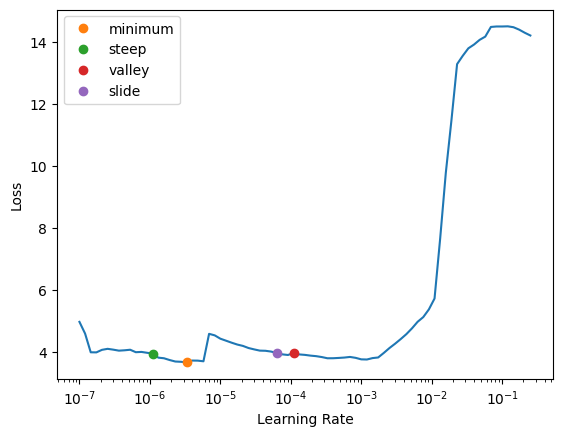

In [ ]:
# Finding Optimal Learning Rate
res = learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
# Installing nltk package
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Running Fine-tuning

#### The Table shows training for BART-Large, but actual model used for inferencing on test set is BART-Base

In [ ]:
df = learn.fit_one_cycle(10, lr_max=res.valley, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,bleu,meteor,sacrebleu,time
0,2.755406,2.575260,0.331311,0.114887,0.198024,0.845247,0.832321,0.838571,0.081817,0.195654,6.993606,12:03
1,2.779331,2.538829,0.327371,0.117989,0.202183,0.856784,0.832988,0.844476,0.073431,0.187462,6.287754,11:21
2,2.465029,2.557344,0.323410,0.112661,0.196658,0.848965,0.830664,0.839530,0.075672,0.188759,6.589156,11:31
3,2.384083,2.546752,0.336723,0.124281,0.204266,0.852311,0.833425,0.842591,0.080627,0.196390,7.152317,11:38
4,1.903038,2.559493,0.342693,0.122606,0.203514,0.854625,0.835893,0.844985,0.084745,0.201654,7.385703,11:44
5,1.511674,2.684903,0.347872,0.125075,0.210854,0.854808,0.837324,0.845825,0.091619,0.205545,7.902192,11:33
6,1.181547,2.827781,0.349934,0.124658,0.210648,0.855019,0.837250,0.845881,0.090192,0.205430,7.651439,11:32
7,0.925430,2.987574,0.351112,0.125116,0.209951,0.856596,0.838058,0.847087,0.092777,0.204480,7.900780,11:31
8,0.739723,3.136092,0.355052,0.127780,0.211756,0.857103,0.838618,0.847596,0.092095,0.204294,7.896360,11:29
9,0.695731,3.196801,0.356191,0.127051,0.211610,0.857847,0.838597,0.847947,0.091951,0.207410,7.871081,11:32


### Printing results obtained after fine-tuning

In [ ]:
res = learn.show_results(learner=learn)

### Saving the model in pickle format

In [ ]:
learn.metrics = None
learn = learn.to_fp32()
learn.export(fname="bar_summary_export.pkl")

In [ ]:
test_article = train_data.iloc[10]
test_article = test_article.article

### Loading Model to perform inferencing

In [ ]:
infer = load_learner(fname="bar_summary_export.pkl")
res = infer.blurr_summarize(test_article)

### Summary obtained

In [ ]:
res[0]['summary_texts']

" background . \n amyloid plaques are implicated in alzheimer 's disease ( ad ) pathology and , owing to the rapid growth of the elderly population , the need for improved methods of early detection \n will become more urgent . in this study , we examined the usefulness of brief neuropsychological tests in combination with blood a140 and a142 as a predictive test for detecting mci / ad in older adults at a pre - symptomatic stage.materials and methods . in a randomized , placebo - controlled , multicenter trial ( adapt ) , subjects were randomly assigned to one of three groups :"

### Ground Truth

In [ ]:
train_data.iloc[10].abstract

'we examined the usefulness of brief neuropsychological tests and serum a as a predictive test for detecting mci / ad in older adults . \n serum a levels were measured from 208 subjects who were cognitively normal at enrollment and blood draw . \n twenty - eight of the subjects subsequently developed mci ( n = 18 ) or ad ( n = 10 ) over the follow - up period . \n baseline measures of global cognition , memory , language fluency , and serum a142 and the ratio of serum a142/a140 were significant predictors for future mci / ad using cox regression with demographic variables , apoe 4 , vascular risk factors , and specific medication as covariates . an optimal sensitivity of 85.2% and specificity of 86.5% for predicting mci / ad was achieved using roc analyses . \n brief neuropsychological tests and measurements of a142 obtained via blood warrants further study as a practical and cost effective method for wide - scale screening for identifying older adults who may be at - risk for patholog